In [150]:
# import modules
import numpy as np
import random
import math

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>

## 1. Two moons with an invertible neural network

In [151]:
# construct a RealNVP
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks # number of coupling layers

        self.D_tilde = self.input_size // 2 # dimension of the first half of the input
        # construct the network: two hidden layers with relu activation and one output layer
        self.nets = nn.ModuleList(nn.Sequential(
            nn.Linear(self.D_tilde, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.D_tilde * 2) # output layer s and t
        ) for _ in range(self.blocks) )
        
        # construct the orthogonal matrix
        self.shuffle = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        self.shuffle_inverse = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        # initialize the orthogonal matrix using a random orthogonal matrix
        for i in range(self.blocks-1):
            # generate a random orthogonal matrix
            Q, _ = torch.linalg.qr(torch.randn(self.input_size, self.input_size))
            # set the parameters of the linear layer to the random orthogonal matrix
            self.shuffle[i].weight.data = Q
            self.shuffle[i].bias.data = torch.zeros(self.input_size)
            self.shuffle_inverse[i].weight.data = Q.t()
            self.shuffle_inverse[i].bias.data = torch.zeros(self.input_size)
        # freeze the orthogonal matrix
        for param in self.shuffle.parameters():
            param.requires_grad = False
        for param in self.shuffle_inverse.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        # for the second half of the dimensions rely on the first half
        log_det_J = 0
        for i in range(self.blocks):
            # the first half of the dimensions are not changed
            x_1 = x[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[i](x_1), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            x_2 = x[:, self.D_tilde:] * torch.exp(torch.tanh(s)) + t
            # combine the first and second half of the dimensions
            x = torch.cat([x_1, x_2], dim=1)
            # update the log determinant of the Jacobian
            log_det_J += torch.sum(torch.log(1 - torch.tanh(s)**2) + torch.tanh(s), dim=1)
            if i != self.blocks-1:
                # change the dimensions by the random orthogonormal matrix
                x = self.shuffle[i](x)
        return x, log_det_J
    
    def inverse(self, z):
        # for the second half of the dimensions rely on the first half
        for i in range(self.blocks):
            if i != 0:
                # change the dimensions by the inverse of the random orthogonormal matrix
                z = self.shuffle_inverse[self.blocks-1-i](z)
            # the first half of the dimensions are not changed
            z_1 = z[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[self.blocks-1-i](z_1), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            z_2 = (z[:, self.D_tilde:] - t) * torch.exp(-torch.tanh(s))
            # combine the first and second half of the dimensions
            z = torch.cat([z_1, z_2], dim=1)
        return z
    
    def sample(self, num_samples):
        # sample from a standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        # apply the inverse of the flow
        x = self.inverse(z)
        return x

In [152]:
# construct a training function
def train_inn(inn, data, batch_size, epochs, visualize=False):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset = data, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.float()
            z, log_det_J = inn(batch)
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
            
            

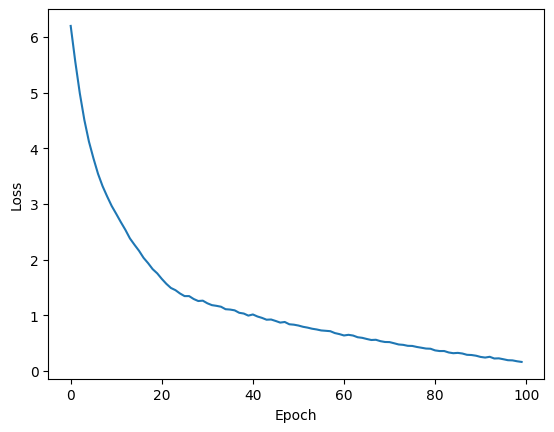

In [153]:
# create a small dataset
n_samples = 1000
n_epochs = 100
blocks = 4
hidden_size = 8
batch_size = 150
input_size = 2

X, _ = make_moons(n_samples=n_samples, noise=.1)

inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=True)

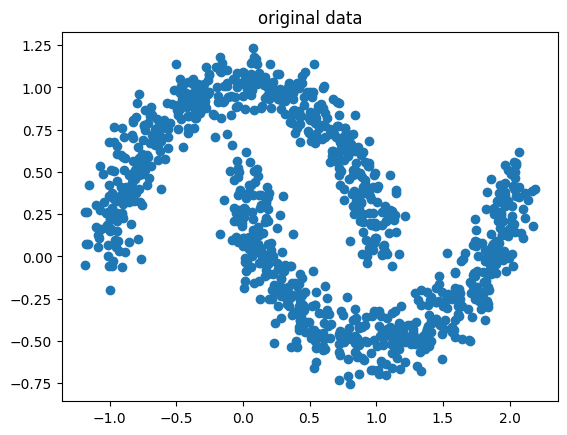

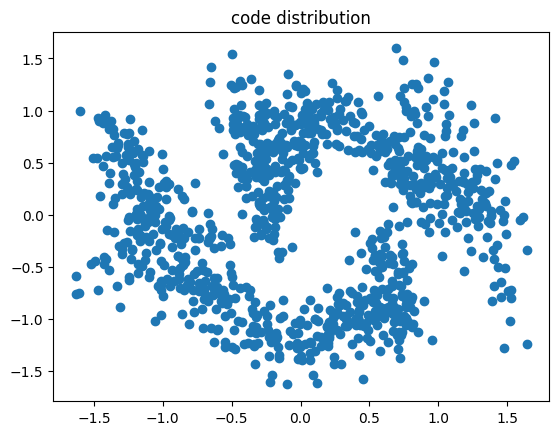

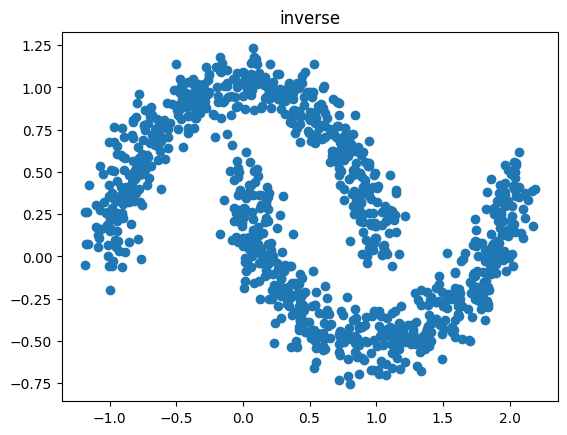

In [154]:
# visualize the original data
X = torch.from_numpy(X).float()
plt.scatter(X[:, 0], X[:, 1])
plt.title('original data')
plt.show()

# visualize the results
z, _ = inn(X)
z = z.detach().numpy()
plt.scatter(z[:, 0], z[:, 1])
plt.title('code distribution')
plt.show()

# visualize the inverse
z = torch.from_numpy(z).float()
X_inv = inn.inverse(z)
X_inv = X_inv.detach().numpy()
plt.scatter(X_inv[:, 0], X_inv[:, 1])
plt.title('inverse')
plt.show()

Comment: The original data points are the same as the inverse data, and the reconstruction errors are 0, incidating that our code works well.

Then we will check the effect of hyperparameters and find the optimal hyperparameter combination.

Training with hidden size 2
Training with hidden size 4
Training with hidden size 8
Training with hidden size 16
Training with hidden size 32
Training with hidden size 64


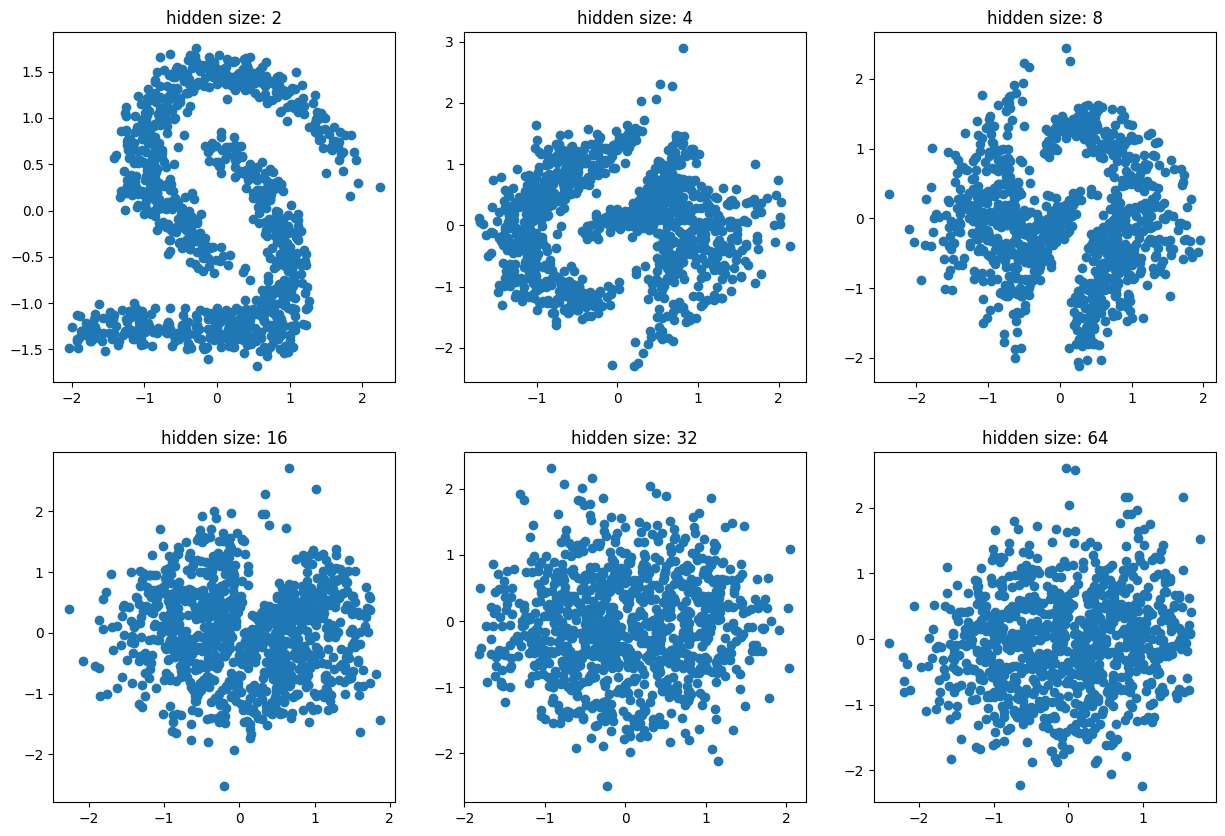

In [155]:
# Check the effect of varying the number of hidden units
n_samples = 1000
n_epochs = 100
blocks = 8
hidden_sizes = [2, 4, 8, 16, 32, 64]

X, _ = make_moons(n_samples=n_samples, noise=.1)
X = torch.from_numpy(X).float()

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, hidden_size in enumerate(hidden_sizes):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with hidden size {hidden_size}')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('hidden size: {}'.format(hidden_size))

Training with 2 blocks
Training with 4 blocks
Training with 6 blocks
Training with 8 blocks
Training with 10 blocks
Training with 12 blocks


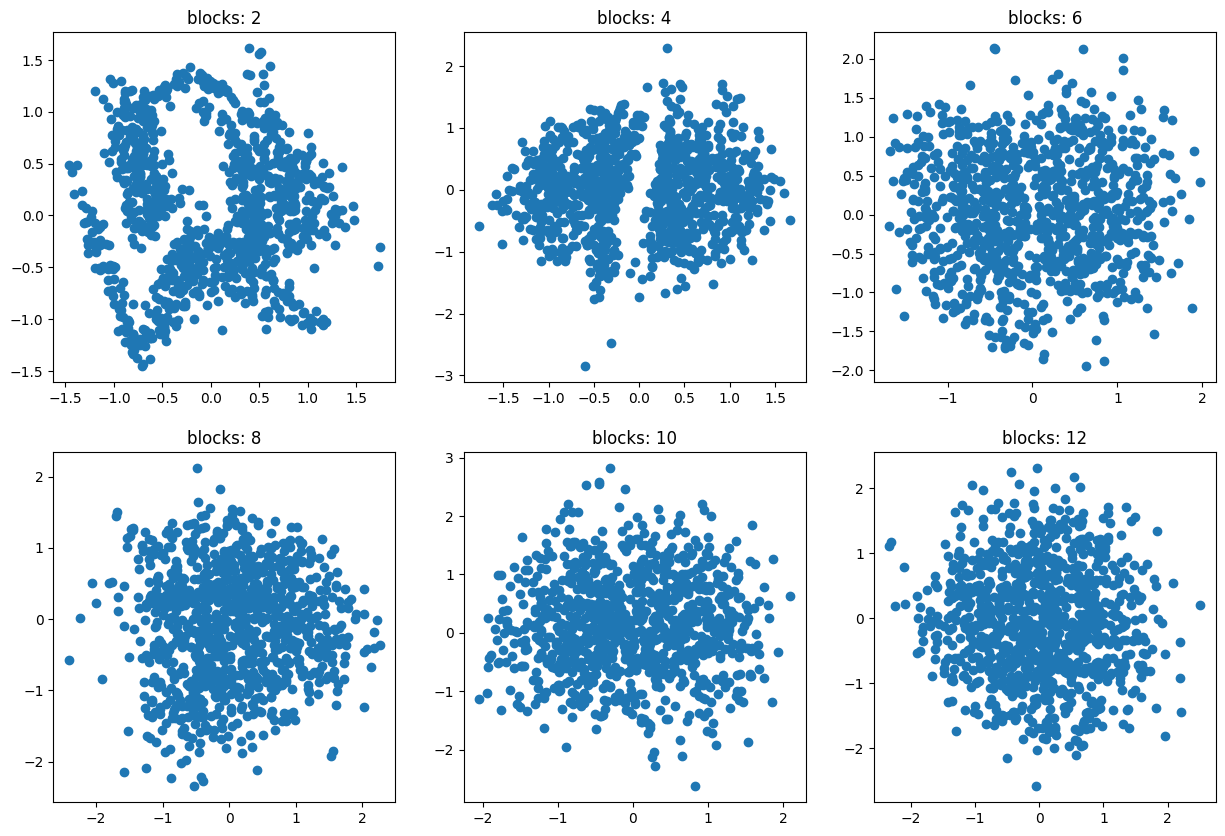

In [156]:
# Check the effect of varying the number of blocks
n_samples = 1000
n_epochs = 100
blocks = [2, 4, 6, 8, 10, 12]
hidden_size = 64

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, block in enumerate(blocks):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=block)
    print(f'Training with {block} blocks')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('blocks: {}'.format(block))

Training with 5 epochs
Training with 10 epochs
Training with 20 epochs
Training with 50 epochs
Training with 100 epochs
Training with 200 epochs


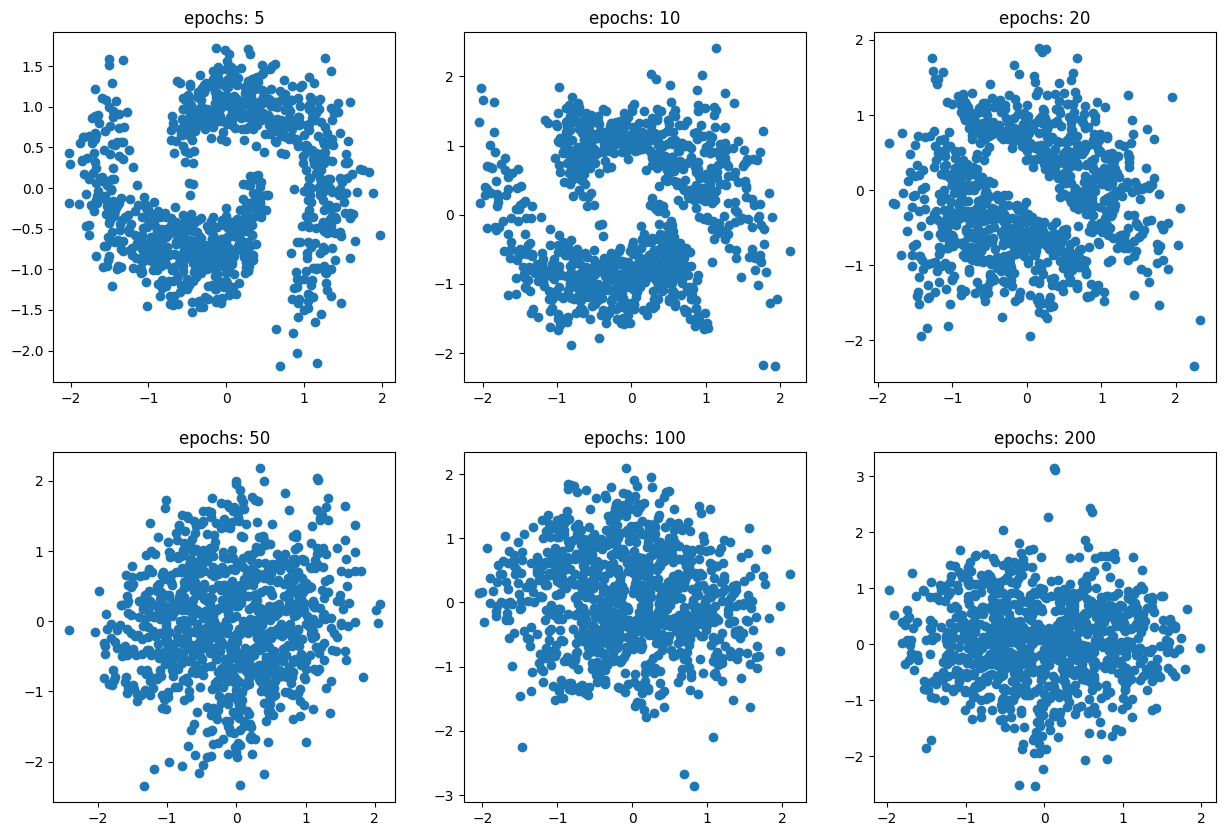

In [157]:
# check the effect of varying the number of epochs
n_samples = 1000
n_epochs = [5, 10, 20, 50, 100, 200]
blocks = 8
hidden_size = 64

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, epoch in enumerate(n_epochs):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with {epoch} epochs')
    train_inn(inn, X, batch_size=batch_size, epochs=epoch)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('epochs: {}'.format(epoch))

Training with batch size 10
Training with batch size 50
Training with batch size 100
Training with batch size 150
Training with batch size 200
Training with batch size 500


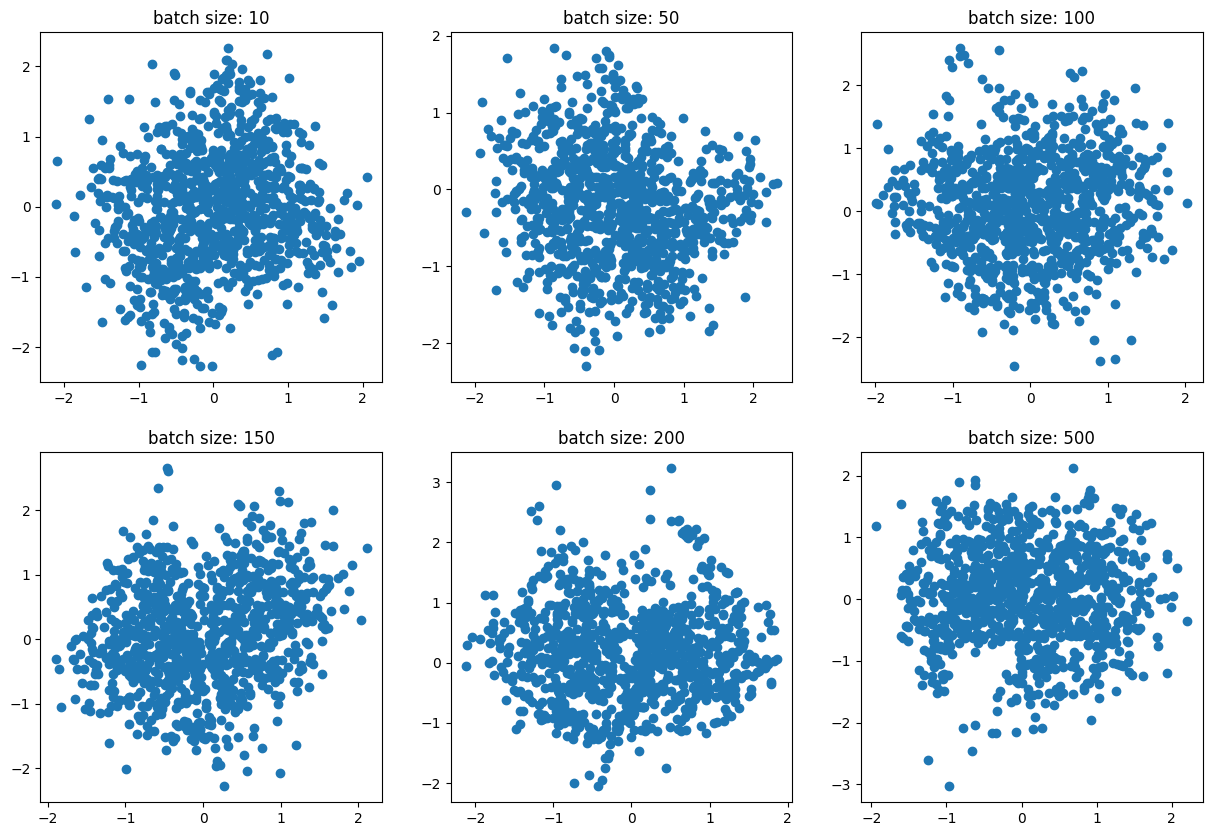

In [158]:
# check the effect of varying the batch size
n_samples = 1000
n_epochs = 100
blocks = 8
hidden_size = 64
batch_sizes = [10, 50, 100, 150, 200, 500]

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, batch_size in enumerate(batch_sizes):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with batch size {batch_size}')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('batch size: {}'.format(batch_size))

Training with 100 samples
Training with 500 samples
Training with 1000 samples
Training with 2000 samples
Training with 5000 samples
Training with 10000 samples


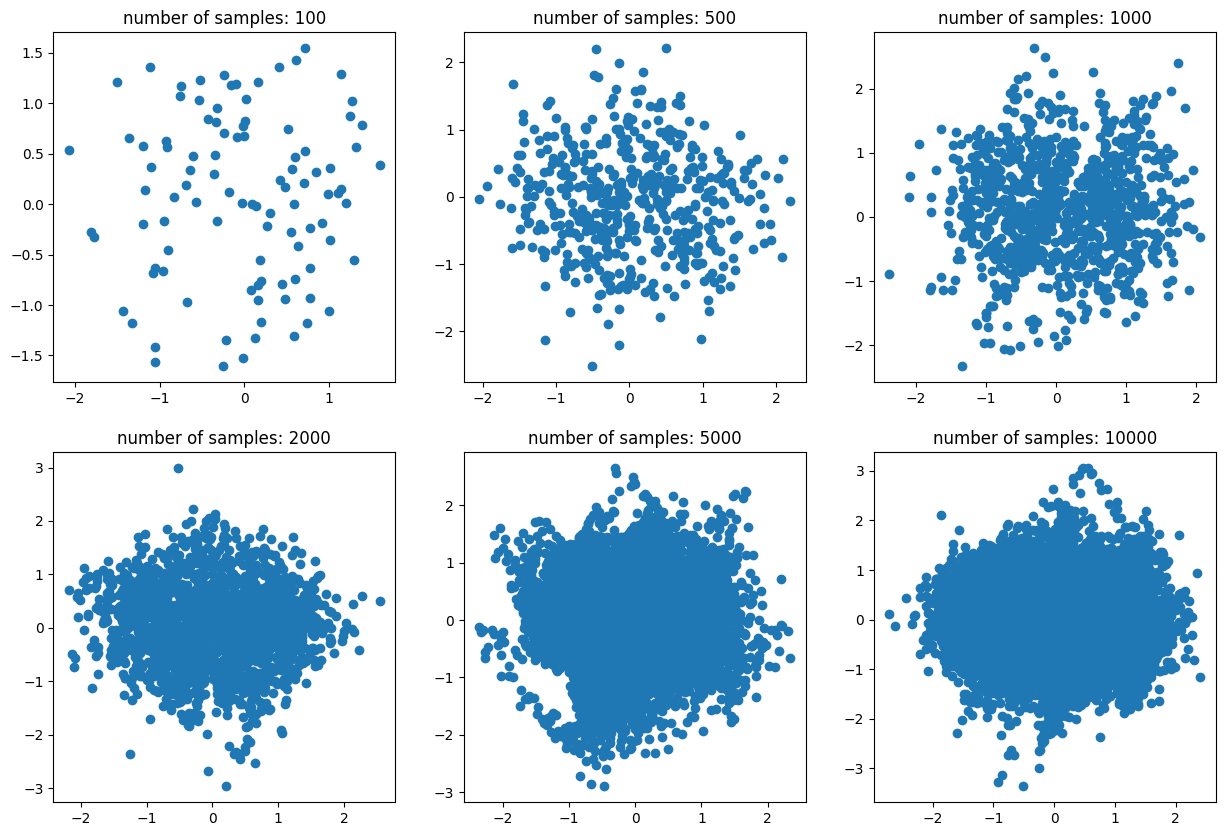

In [159]:
# check the effect of varying the number of samples
n_samples = [100, 500, 1000, 2000, 5000, 10000]
n_epochs = 100
blocks = 8
hidden_size = 64
batch_size = 150

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, n_sample in enumerate(n_samples):
    X, _ = make_moons(n_samples=n_sample, noise=.1)
    X = torch.from_numpy(X).float()
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with {n_sample} samples')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('number of samples: {}'.format(n_sample))

Comment: We found that number of samples = 2000, epoch_size = 150, hidden_size = 64, blocks = 8, epoch = 100 could generate code distribution most like standard normal.

In [160]:
# implement the MMD metric with squared exponential kernel and inverse multiquadric kernel
def squared_exponential_kernel(x, y, h = 1):
    return np.exp(-np.linalg.norm(x-y)**2/(2*h))

def inverse_multiquadric_kernel(x, y, h = 1):
    return 1/np.sqrt(np.linalg.norm(x-y)**2 / h + 1)

def MMD2(X, Y, kernel_type, h):
    # X, Y: numpy array
    # return: scalar
    n = len(X)
    m = len(Y)
    if kernel_type == 'squared_exponential':
        kernel = squared_exponential_kernel
    elif kernel_type == 'inverse_multiquadric':
        kernel = inverse_multiquadric_kernel
    else:
        raise ValueError('kernel_type must be squared_exponential or inverse_multiquadric')
    K_XX = np.array([[kernel(X[i], X[j], h) for j in range(n) if j != i] for i in range(n)])
    K_XY = np.array([[kernel(X[i], Y[j], h) for j in range(m)] for i in range(n)])
    K_YY = np.array([[kernel(Y[i], Y[j], h) for j in range(m) if j != i] for i in range(m)])
    return 1/(n*(n-1)) * np.sum(K_XX) - 2/(n*m) * np.sum(K_XY) + 1/(m*(m-1)) * np.sum(K_YY)


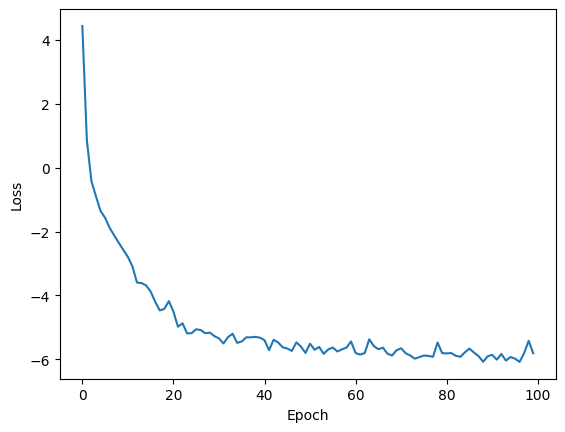

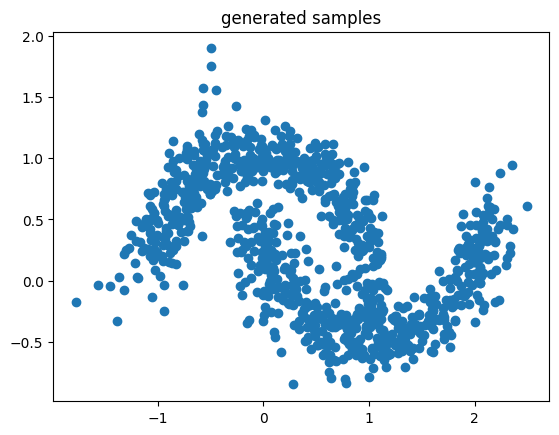

The MMD distance between the generated samples and the original data is 0.00043473123109560863


In [161]:
# optimal parameters
n_samples = 2000
n_epochs = 100
blocks = 8
hidden_size = 64
batch_sizes = 150

# train the model
X, _ = make_moons(n_samples=n_samples, noise=.1)
X = torch.from_numpy(X).float()
inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=True)

# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
z_inv = inn.inverse(z)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
plt.scatter(z_inv[:, 0], z_inv[:, 1])
plt.title('generated samples')
plt.show()

# compute the MMD between the generated samples and the original data
MMD_dist = MMD2(z_inv, X.detach().numpy(), kernel_type='squared_exponential', h=1)
print(f'The MMD distance between the generated samples and the original data is {MMD_dist}')

Training with 2 blocks
Training with 4 blocks
Training with 8 blocks


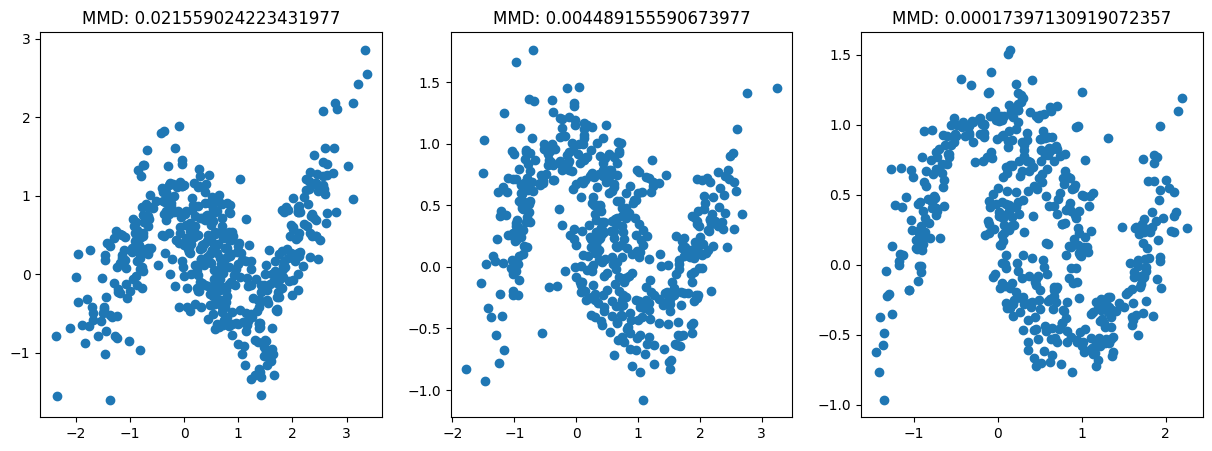

In [162]:
# show that the smaller MMD means better visualization result

n_samples = 500
n_epochs = 100
n_blocks = [2,4,8]
hidden_size = 64
batch_size = 150

# create a 2*3 grid of plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
for i, n_block in enumerate(n_blocks):
    X, _ = make_moons(n_samples=n_samples, noise=.1)
    X = torch.from_numpy(X).float()
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=n_block)
    print(f'Training with {n_block} blocks')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z = torch.randn(n_samples, input_size)
    z_inv = inn.inverse(z)
    z_inv = z_inv.detach().numpy()
    MMD_dist = MMD2(z_inv, X.detach().numpy(), kernel_type='squared_exponential', h=1)
    axs[i].scatter(z_inv[:, 0], z_inv[:, 1])
    axs[i].set_title('MMD: {}'.format(MMD_dist))

(6, 2)


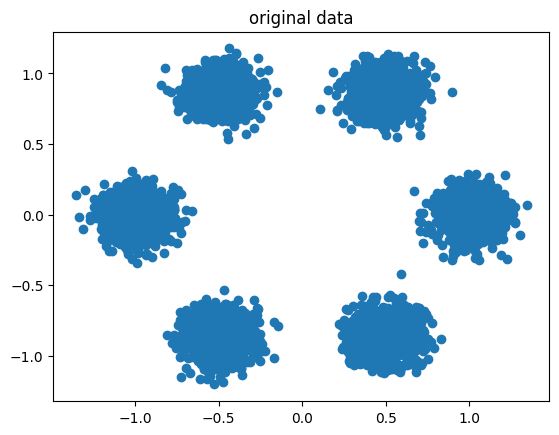

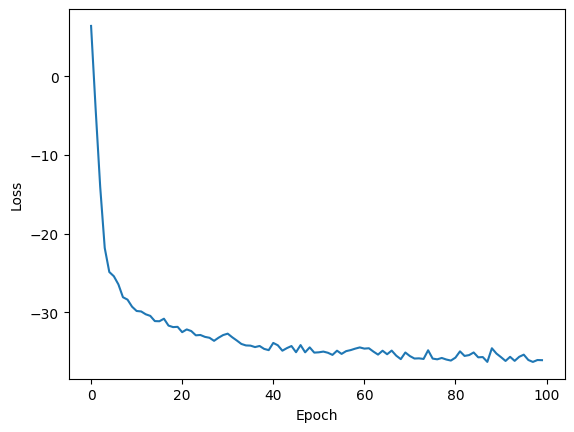

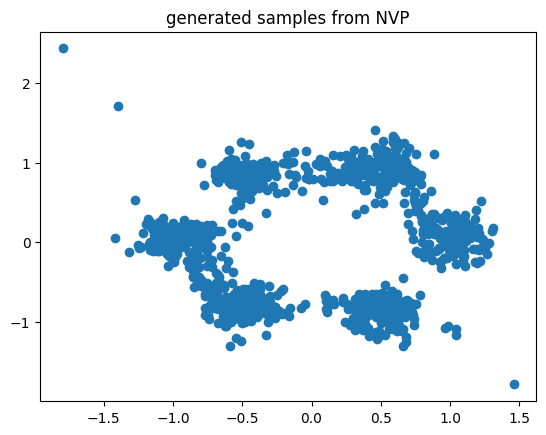

In [163]:
# create a new dataset with Gaussian mixture setting
# create a hexagon and vertices as the center of the Gaussian mixture components
mu = np.array([(math.cos(2*math.pi/6*i), math.sin(2*math.pi/6*i)) for i in range(6)])
# create a dataset with 10000 samples with standard deviation 1/10
sigma = 0.1

print(mu.shape)
# create a Gaussian mixture model dataset
X = np.array([np.random.normal(mu[i], sigma) for i in range(6) for _ in range(1000)])

# visualize the dataset
plt.scatter(X[:, 0], X[:, 1])
plt.title('original data')
plt.show()

# train the model
X = torch.from_numpy(X).float()
inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=True)

# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
z_inv = inn.inverse(z)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
plt.scatter(z_inv[:, 0], z_inv[:, 1])
plt.title('generated samples from NVP')
plt.show()

Comment: Yes, the generated samples from RealNVP are trying to connect the isolated parts of different Gaussian components. The discrete GMM generated shape is indeed harder to process since the network is made up of continuous invertible projections.

<div style="color:green; font-weight:bold">
Comment: 

1. The code is fundamentally correct, with the exception of the loss function. The log determinant should be the derivative of \(x_2\) with respect to \(s\) before scaling. However, in the Working Example (WE), the derivative of \(x_2\) is taken with respect to \(s\) after scaling. The approach in the WE seems more appropriate, as we need to compute the derivative of \(J\) with respect to \(x_{j}\) for \(j \geq \tilde{D}\).

2. An additional point of elegance in the WE is the encapsulation of the coupling_block within a class, which enhances flexibility and modularity.

3. In our code, we have focused on assessing the impact of each hyperparameter on the code distribution, rather than on the generated samples.

4. Regarding the GMM example, the classification results were not as good as expected, suggesting that a different architecture might be worth exploring.
</div>


## 2. Two moons with a conditional invertible neural network

In [164]:
# extend the RealNVP to a conditional RealNVP
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size):
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks # number of coupling layers
        self.condition_size = condition_size

        self.D_tilde = self.input_size // 2 # dimension of the first half of the input
        # construct the network: two hidden layers with relu activation and one output layer
        self.nets = nn.ModuleList(nn.Sequential(
            nn.Linear(self.D_tilde + self.condition_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.D_tilde * 2) # output layer s and t
        ) for _ in range(self.blocks) )
        
        # construct the orthogonal matrix
        self.shuffle = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        self.shuffle_inverse = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        # initialize the orthogonal matrix using a random orthogonal matrix
        for i in range(self.blocks-1):
            # generate a random orthogonal matrix
            Q, _ = torch.linalg.qr(torch.randn(self.input_size, self.input_size))
            # set the parameters of the linear layer to the random orthogonal matrix
            self.shuffle[i].weight.data = Q
            self.shuffle[i].bias.data = torch.zeros(self.input_size)
            self.shuffle_inverse[i].weight.data = Q.t()
            self.shuffle_inverse[i].bias.data = torch.zeros(self.input_size)
        # freeze the orthogonal matrix
        for param in self.shuffle.parameters():
            param.requires_grad = False
        for param in self.shuffle_inverse.parameters():
            param.requires_grad = False
            
    def forward(self, x, y):
        # for the second half of the dimensions rely on the first half
        log_det_J = 0
        for i in range(self.blocks):
            # the first half of the dimensions are not changed
            x_1 = x[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[i](torch.cat([x_1, y], dim=1)), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            x_2 = x[:, self.D_tilde:] * torch.exp(torch.tanh(s)) + t
            # combine the first and second half of the dimensions
            x = torch.cat([x_1, x_2], dim=1)
            # update the log determinant of the Jacobian
            log_det_J += torch.sum(torch.log(1 - torch.tanh(s)**2) + torch.tanh(s), dim=1)
            if i != self.blocks-1:
                # change the dimensions by the random orthogonormal matrix
                x = self.shuffle[i](x)
        return x, log_det_J
      
    def inverse(self, z, y):
        # for the second half of the dimensions rely on the first half
        for i in range(self.blocks):
            if i != 0:
                # change the dimensions by the inverse of the random orthogonormal matrix
                z = self.shuffle_inverse[self.blocks-1-i](z)
            # the first half of the dimensions are not changed
            z_1 = z[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[self.blocks-1-i](torch.cat([z_1, y], dim=1)), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            z_2 = (z[:, self.D_tilde:] - t) * torch.exp(-torch.tanh(s))
            # combine the first and second half of the dimensions
            z = torch.cat([z_1, z_2], dim=1)
        return z
      
    def sample(self, num_samples, conditions):
        # sample from a standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        # apply the inverse of the flow
        x = self.inverse(z, conditions)
        return x

In [165]:
# function to train the conditional RealNVP
def train_conditional_inn(inn, data, condition, batch_size, epochs, visualize=False):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    dataset = list(zip(data, condition))
    train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            X_batch, condition_batch = batch
            X_batch = X_batch.float()
            condition_batch = condition_batch.float()
            optimizer.zero_grad()
            z, log_det_J = inn(X_batch, condition_batch)
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

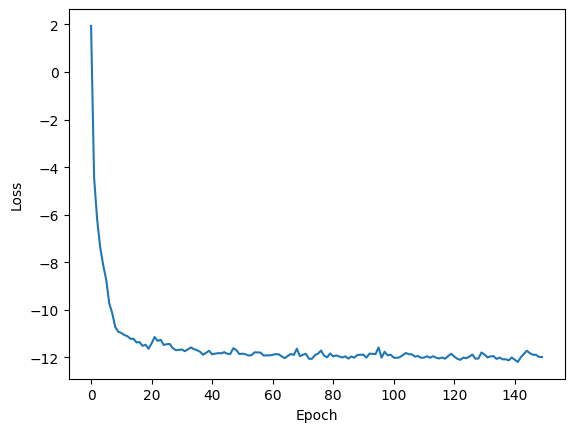

In [166]:
# first use the Moons dataset
n_samples = 2000
n_epochs = 150
blocks = 8
hidden_size = 64
batch_size = 150
input_size = 2
condition_size = 1

X, y = make_moons(n_samples=n_samples, noise=.1)
y = y.reshape(-1, 1)
inn = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn(inn, X, y, batch_size=batch_size, epochs=n_epochs, visualize=True)

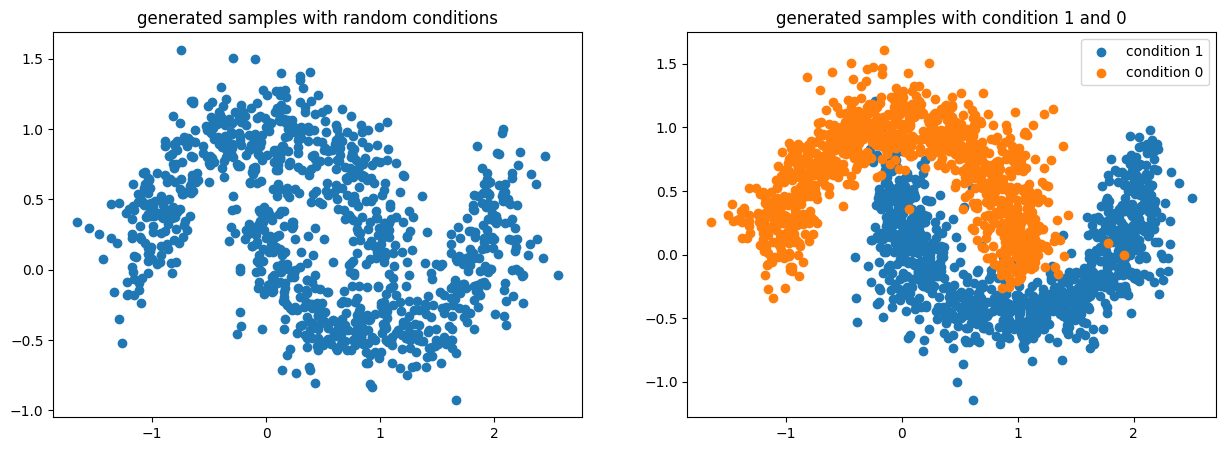

In [167]:
# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
conditions = torch.from_numpy(np.random.randint(0, 2, num_samples)).float().view(-1, 1)
conditions_1 = torch.ones(num_samples, 1).float().view(-1, 1)
conditions_0 = torch.zeros(num_samples, 1).float().view(-1, 1)
z_inv = inn.sample(num_samples, conditions)
z_inv_1 = inn.sample(num_samples, conditions_1)
z_inv_0 = inn.sample(num_samples, conditions_0)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
z_inv_1 = z_inv_1.detach().numpy()
z_inv_0 = z_inv_0.detach().numpy()

# plot two figures: one with random conditions and one with condition 1 and 0 in different colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(z_inv[:, 0], z_inv[:, 1])
axs[0].set_title('generated samples with random conditions')
axs[1].scatter(z_inv_1[:, 0], z_inv_1[:, 1], label='condition 1')
axs[1].scatter(z_inv_0[:, 0], z_inv_0[:, 1], label='condition 0')
axs[1].set_title('generated samples with condition 1 and 0')
axs[1].legend()
plt.show()



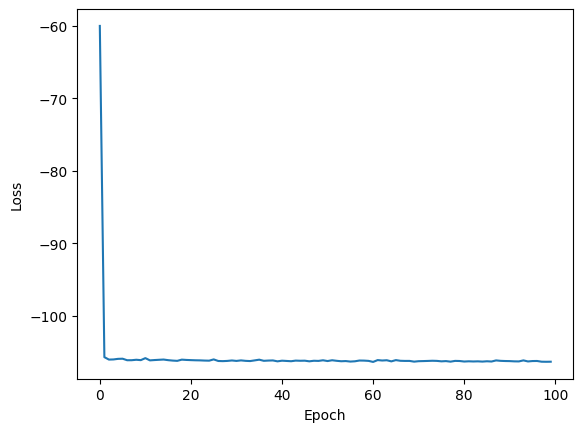

In [168]:
# Create a new dataset with Gaussian mixture setting
num_samples = 10000
# conditions in one-hot encoding; random conditions
conditions_index = np.random.randint(0, 6, num_samples)
conditions = np.eye(6)[conditions_index]
# create a hexagon and vertices as the center of the Gaussian mixture components
mu = np.array([(math.cos(2*math.pi/6*i), math.sin(2*math.pi/6*i)) for i in range(6)])
# create a dataset with 10000 samples with standard deviation 1/10
sigma = 0.1
# create a Gaussian mixture model dataset with conditions
X = np.array([np.random.normal(mu[conditions_index[i]], sigma) for i in range(num_samples)])

# initialize and train the conditional RealNVP
condition_size = 6
input_size = 2
blocks = 8
hidden_size = 64
batch_size = 150
n_epochs = 100

inn = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn(inn, X, conditions, batch_size=batch_size, epochs=n_epochs, visualize=True)

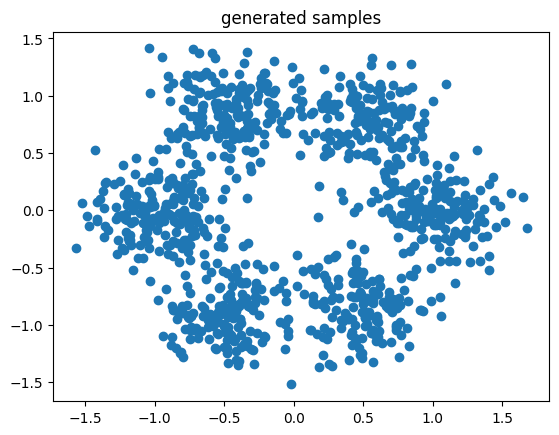

In [169]:
# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
conditions = torch.from_numpy(np.eye(6)[np.random.randint(0, 6, num_samples)]).float()
z_inv = inn.sample(num_samples, conditions)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
plt.scatter(z_inv[:, 0], z_inv[:, 1])
plt.title('generated samples')
plt.show()

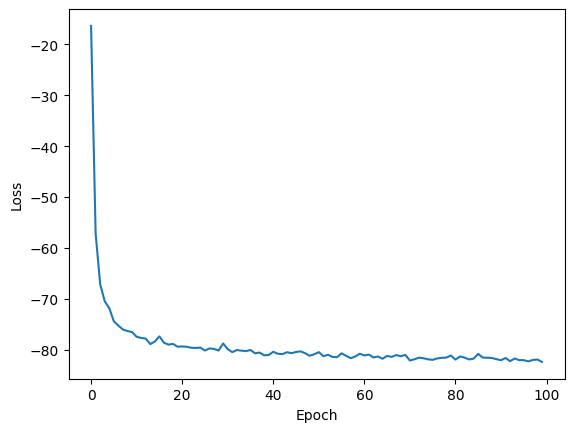

In [170]:
# create a new dataset with Gaussian mixture setting with only 2 conditions
num_samples = 10000
# conditions: two peaks (index = 0 or 3) are 1, the rest are 0
conditions_index = np.random.randint(0, 6, num_samples)
conditions = (conditions_index == 0) | (conditions_index == 3)
conditions = conditions.astype(int).reshape(-1, 1)

# create a hexagon and vertices as the center of the Gaussian mixture components
mu = np.array([(math.cos(2*math.pi/6*i), math.sin(2*math.pi/6*i)) for i in range(6)])
# create a dataset with 10000 samples with standard deviation 1/10
sigma = 0.1
# create a Gaussian mixture model dataset with conditions
X = np.array([np.random.normal(mu[conditions_index[i]], sigma) for i in range(num_samples)])

# initialize and train the conditional RealNVP
condition_size = 1
input_size = 2
blocks = 8
hidden_size = 64
batch_size = 150
n_epochs = 100

inn = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn(inn, X, conditions, batch_size=batch_size, epochs=n_epochs, visualize=True)


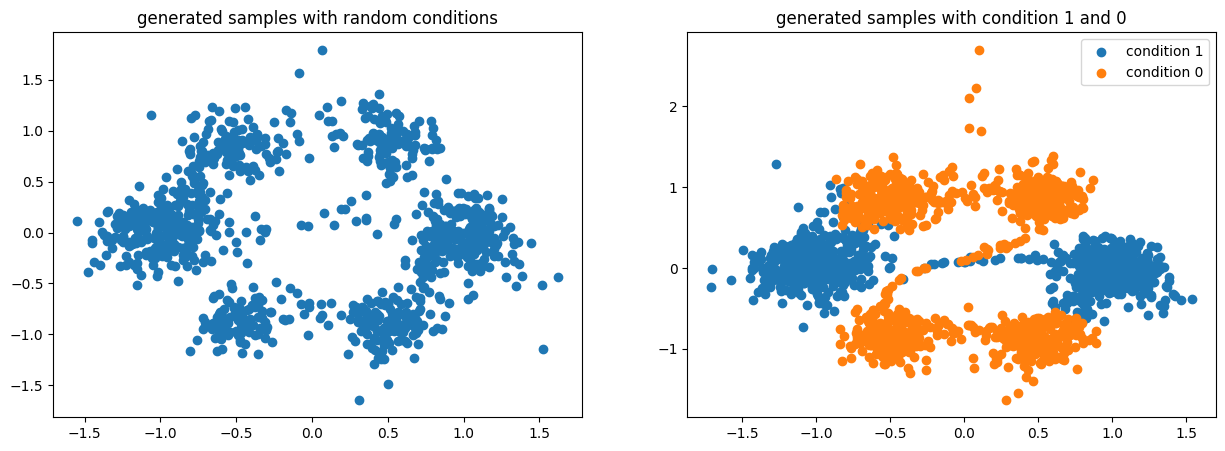

In [171]:
# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
conditions = torch.from_numpy(np.random.randint(0, 2, num_samples)).float().view(-1, 1)
conditions_1 = torch.ones(num_samples, 1).float().view(-1, 1)
conditions_0 = torch.zeros(num_samples, 1).float().view(-1, 1)
z_inv = inn.sample(num_samples, conditions)
z_inv_1 = inn.sample(num_samples, conditions_1)
z_inv_0 = inn.sample(num_samples, conditions_0)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
z_inv_1 = z_inv_1.detach().numpy()
z_inv_0 = z_inv_0.detach().numpy()

# plot two figures: one with random conditions and one with condition 1 and 0 in different colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(z_inv[:, 0], z_inv[:, 1])
axs[0].set_title('generated samples with random conditions')
axs[1].scatter(z_inv_1[:, 0], z_inv_1[:, 1], label='condition 1')
axs[1].scatter(z_inv_0[:, 0], z_inv_0[:, 1], label='condition 0')
axs[1].set_title('generated samples with condition 1 and 0')
axs[1].legend()
plt.show()

<div style="color:green; font-weight:bold">

Comment: The code is essentially correct, but the same problem is the loss function as before. We should modify the loss function as in the Working Example (WE), the derivative of \(J\) with respect to \(x_{j}\) for \(j \geq \tilde{D}\).

Regarding the GMM generation distribution, we did not provide comments because we incorrectly set the points centered at 1 and -1 as condition 1, while the problem actually requires the peaks. We believe that correcting these two points would allow us to generate results similar to the expected ones.

The minor problem is that we did not report the MMD distance between the generative samples and true samples.
</div>

## 3. Higher-dimensional data with an INN

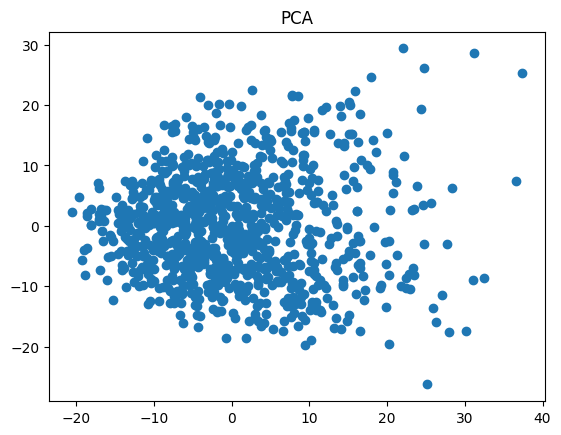

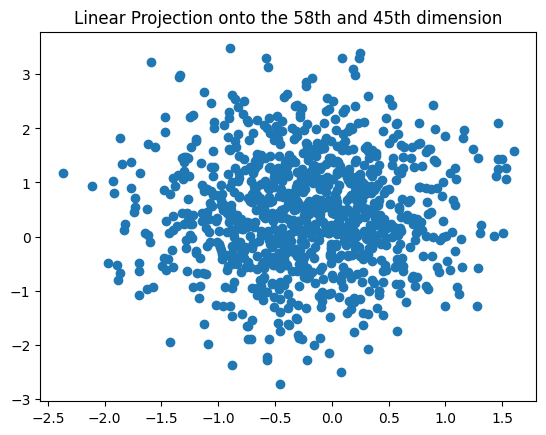

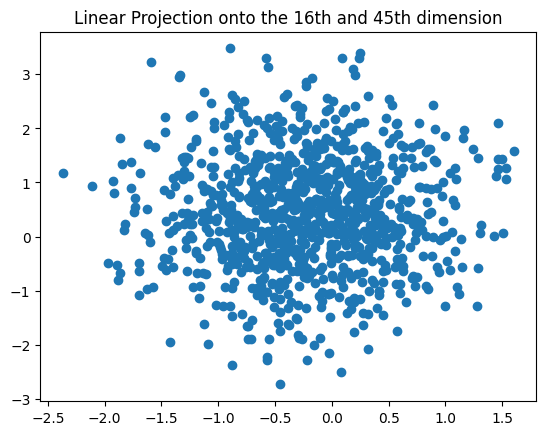

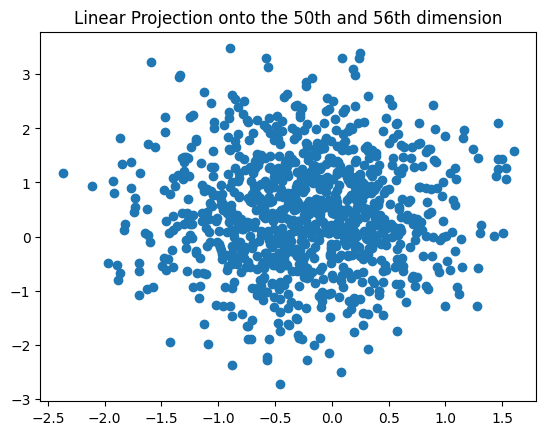

In [172]:
# create a small dataset
n_epochs = 100
blocks = 4
hidden_size = 128
batch_size = 150
input_size = 64

X = load_digits()["data"]

inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=False)

# plot 2D projections
num_samples = 1000
samples = inn.sample(num_samples).detach().numpy()
pca = PCA(n_components=2)
projected_data = pca.fit_transform(samples)
plt.scatter(projected_data[:,0],projected_data[:,1])
plt.title("PCA")
plt.show()
for _ in range(3):
    i = random.randint(0,63)
    j = random.randint(0,63)
    while j == i:
        j = random.randint(0,63)
    plt.scatter(samples[:,0],samples[:,1])
    plt.title("Linear Projection onto the "+str(i)+"th and "+str(j)+"th dimension")
    plt.show()

The distributions in code space are indeed normally distributed.

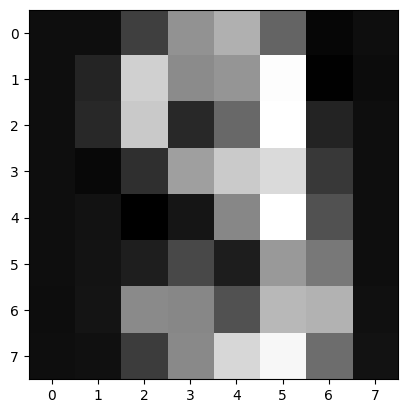

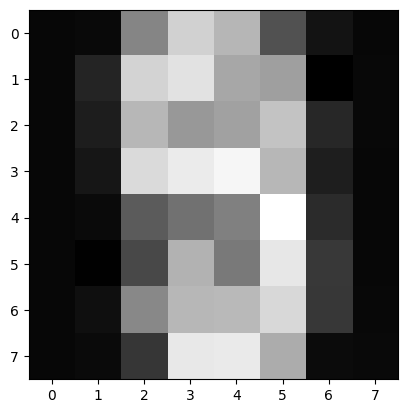

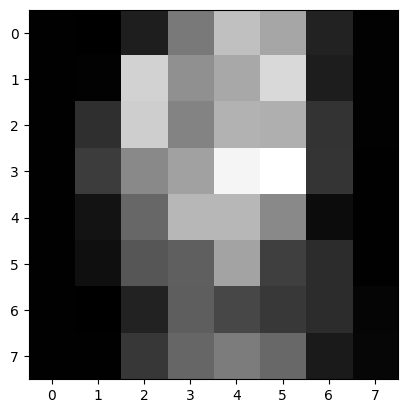

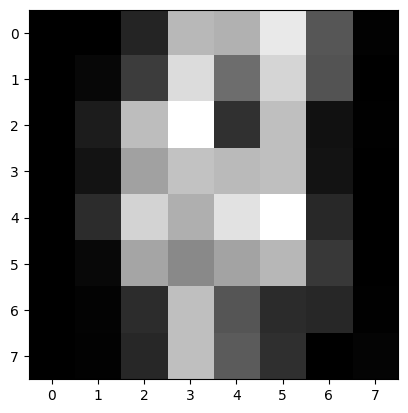

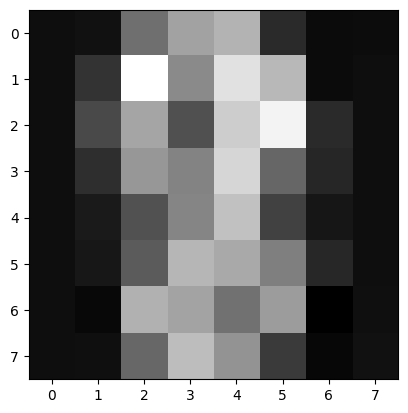

In [173]:
# Generate samples using the inverse function of our model
generated_samples = inn.inverse(torch.randn(5,64)).detach().numpy()

# Rescale the generated samples to the original scale
generated_samples_rescaled = generated_samples * X.std(axis=0) + X.mean(axis=0)

for sample in generated_samples_rescaled:
    plt.imshow(sample.reshape(8, 8), cmap="gray")
    plt.show()

The results are indeed very bad. The explanation that the higher dimensionality seems exceptable, since the number of samples needed to pack a space in the same density grows exponentially with the dimensionality. 

In [174]:
# construct a new training function
def train_inn_recon(inn, data, batch_size, epochs, visualize=False, k=8):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset = data, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.float()
            z, log_det_J = inn(batch)
            z_recon = z
            z_recon[:,k:] = 0
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J) + torch.mean((inn.inverse(z_recon)-batch)**2)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

<div style="color:green; font-weight:bold">

Comment: Our code is essentially correct, while the sample solution did not batch the input. The aforementioned difference between our loss function and the given solution persists, and according to the sample solution, it will perhaps provide more insight to the performance if we run the network on a single digit.
</div>

<class 'numpy.ndarray'>


Text(0.5, 0.98, 'generated samples')

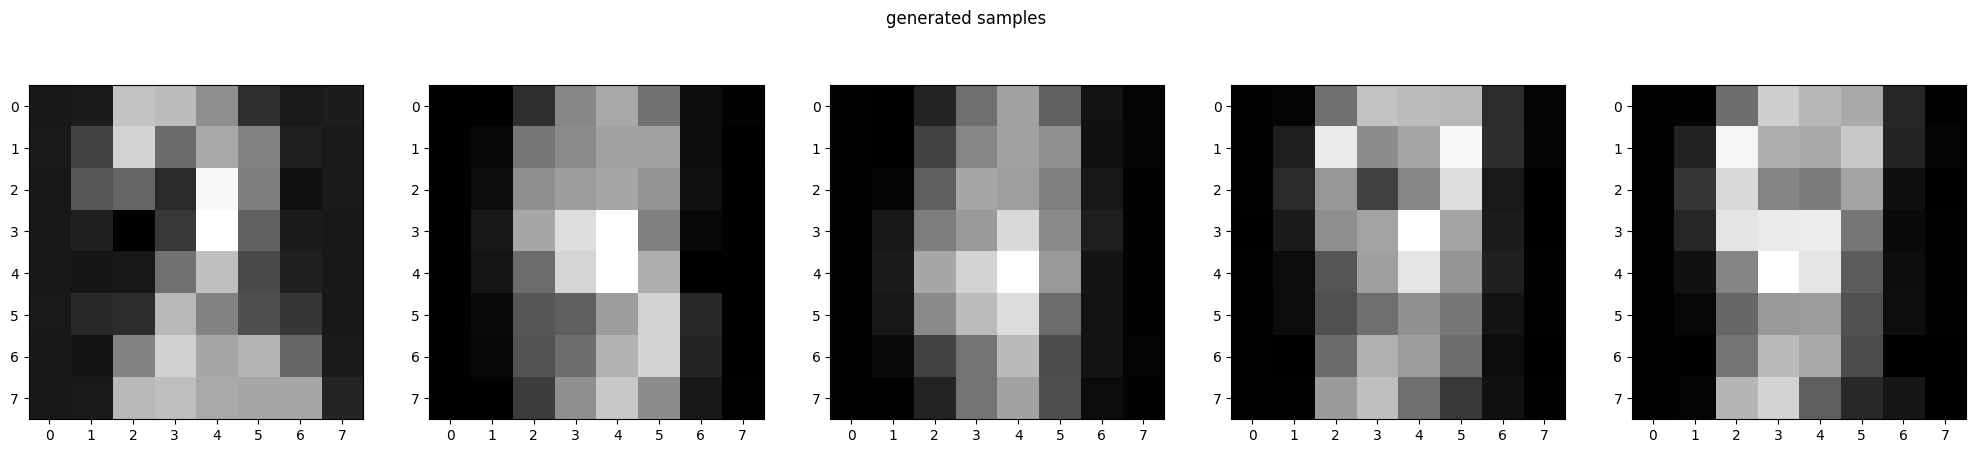

In [175]:
# create a small dataset
n_epochs = 100
blocks = 4
hidden_size = 128
batch_size = 150
input_size = 64
k = 4

X = load_digits()["data"]

print(type(X))

inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn_recon(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=False, k=k)

# Generate samples using the inverse function of our model with details set to zero
z = torch.randn(5,64)
z[:,k:] = 0
generated_samples = inn.inverse(z).detach().numpy()

# Rescale the generated samples to the original scale
generated_samples_rescaled = generated_samples * X.std(axis=0) + X.mean(axis=0)

fig, axs = plt.subplots(ncols=len(generated_samples), nrows =1, figsize = (len(generated_samples)*5, 5))
for i in range(len(generated_samples_rescaled)):#
    sample = generated_samples_rescaled[i]
    ax = axs[i]
    ax.imshow(sample.reshape(8, 8), cmap="gray")
fig.suptitle("generated samples")

Text(0.5, 0.98, 'generated samples')

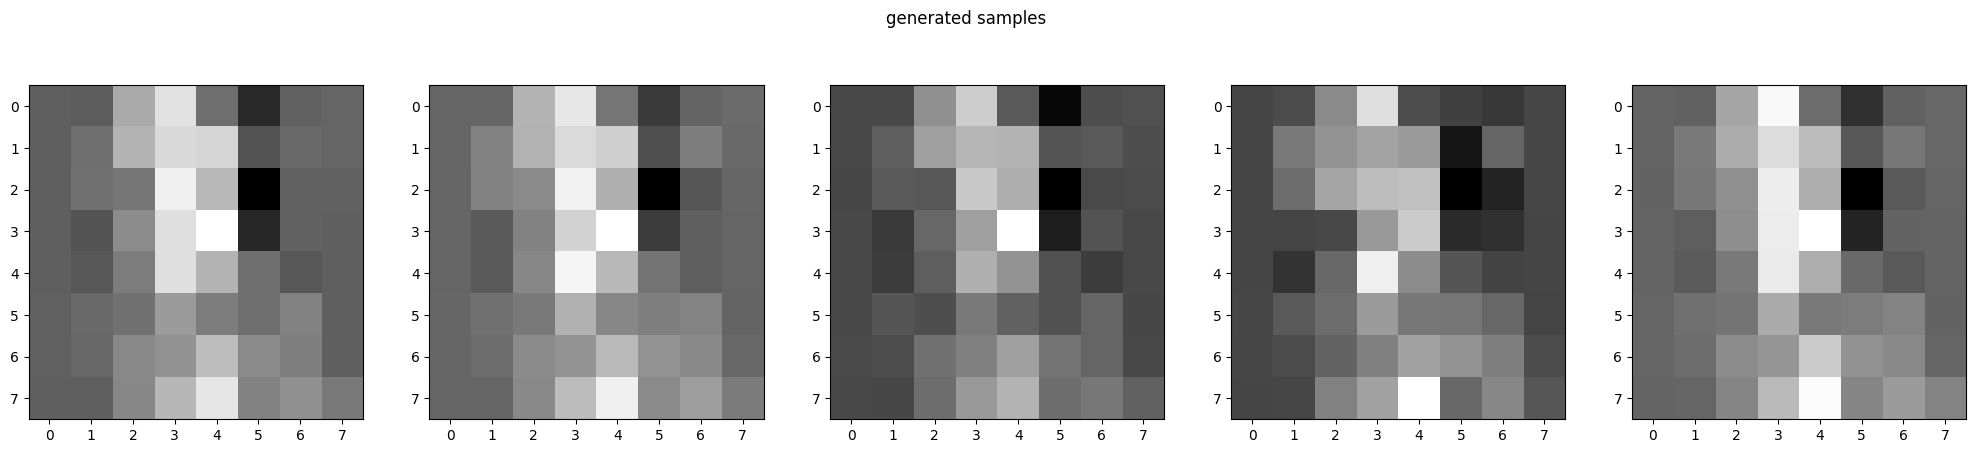

In [176]:
# Generate samples using the inverse function of our model with first dims set to fixed val
# while sampling remaining dim from std normal
z = torch.randn(5,64)
z[:,:k] = float(X.mean())
generated_samples = inn.inverse(z).detach().numpy()

# Rescale the generated samples to the original scale
generated_samples_rescaled = generated_samples * X.std(axis=0) + X.mean(axis=0)

fig, axs = plt.subplots(ncols=len(generated_samples), nrows =1, figsize = (len(generated_samples)*5, 5))
for i in range(len(generated_samples_rescaled)):#
    sample = generated_samples_rescaled[i]
    ax = axs[i]
    ax.imshow(sample.reshape(8, 8), cmap="gray")
fig.suptitle("generated samples")

The quality seems to improve slightly, but this is so limited that it may only be perceptual bias or chance. We can observe the described behaviour in so far that the images created with constant value for the non detail codes all look very similar and only differ in detail, while the ones only varying the non detail codes produce very different outputs.

<div style="color:green; font-weight:bold">

Comment: The problem of this part of the code mainly is that we failed to apply a more detailed and concrete measurement for the performance of the network and the training quality. The sample solution calculated the MMD value, which should be informative. 

Despite flaws, the network did perform as expected, with bottleneck resulting in behavior similar to an encoder.
</div>

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )
<class 'torchvision.datasets.mnist.MNIST'>
0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


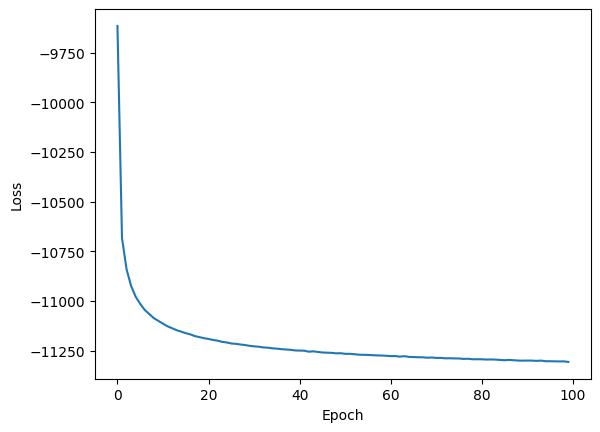

In [177]:
from torchvision import datasets , transforms
from PIL import Image, ImageFilter # install 'pillow' to get PIL

# define a functor to downsample images
class DownsampleTransform:
    def __init__(self, target_shape, algorithm=Image.Resampling.LANCZOS):
        self.width , self.height = target_shape 
        self.algorithm = algorithm
        
    def __call__(self, img):
        img = img.resize((self.width+2, self.height+2), self.algorithm) 
        img = img.crop((1, 1, self.width+1, self.height+1))
        return img

# concatenate a few transforms
transform = transforms.Compose([ DownsampleTransform(target_shape=(8,8)), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# download MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform , download=True)

print(mnist_dataset)

# create a DataLoader that serves minibatches of size 100 
# data_loader = DataLoader(mnist_dataset , batch_size=100, shuffle=True) # not needed in our setup

# visualize the first batch of downsampled MNIST images TODO: Why does this provided code do nothing?
#def show_first_batch(data_loader): 
#    for batch in data_loader:
#        x, y = batch
#        fig = plt.figure(figsize=(10, 10))
#        for i, img in enumerate(x):
#            ax = fig.add_subplot(10, 10, i+1) 
#            ax.imshow(img.reshape(8, 8), cmap='gray') 
#            ax.axis('off')
#        break

# create a small dataset
n_epochs = 100
blocks = 4
hidden_size = 128
batch_size = 150
input_size = 64

inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)

def train_inn_mnist(inn, data, batch_size, epochs, visualize=False):
    print(type(data))
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset = data, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        if epoch%10 == 0:
            print(f"{epoch}/{epochs}")
        running_loss = 0
        for batch in train_loader:
            batch = batch[0].reshape(batch_size,64)
            optimizer.zero_grad()
            batch = batch.float()
            z, log_det_J = inn(batch)
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

train_inn_mnist(inn=inn, data=mnist_dataset, batch_size=batch_size, epochs=n_epochs, visualize=True)

Text(0.5, 0.98, 'generated samples')

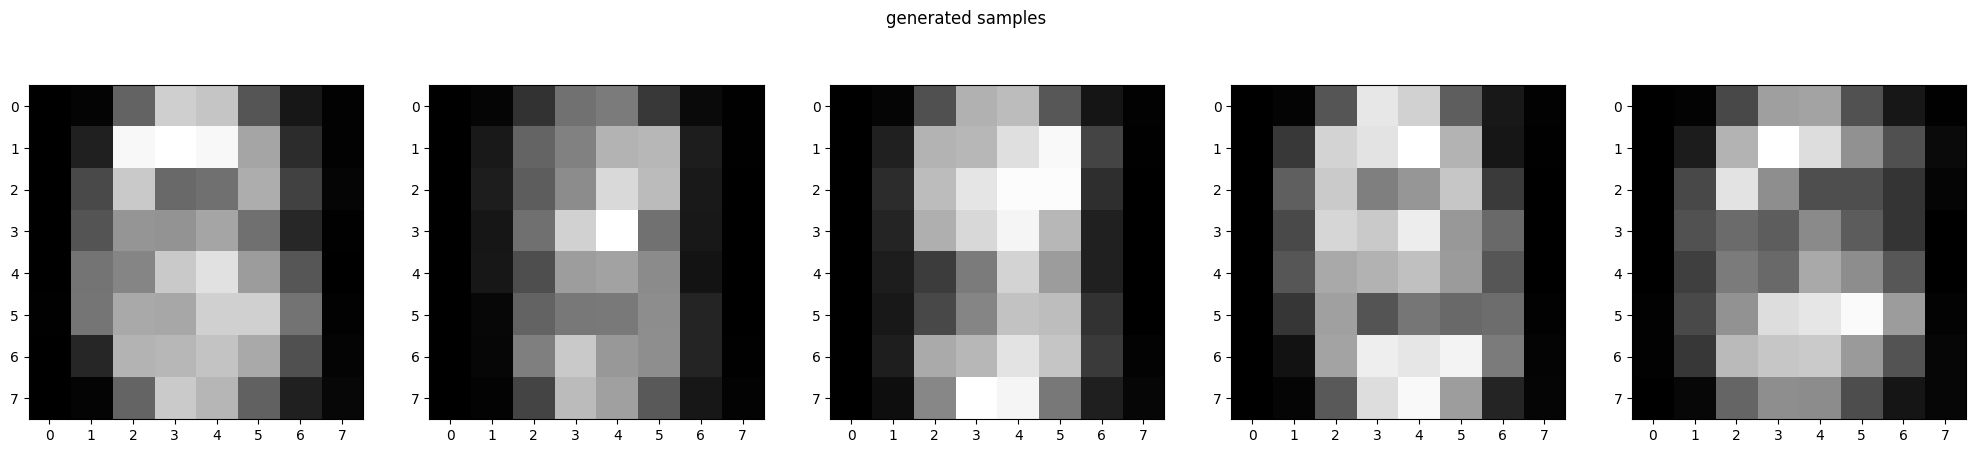

In [178]:
# visualisation:
z = torch.randn(5,64)
z[:,k:] = 0
generated_samples = inn.inverse(z).detach().numpy()

# Rescale the generated samples to the original scale
generated_samples_rescaled = generated_samples * X.std(axis=0) + X.mean(axis=0)

fig, axs = plt.subplots(ncols=len(generated_samples), nrows =1, figsize = (len(generated_samples)*5, 5))
for i in range(len(generated_samples_rescaled)):#
    sample = generated_samples_rescaled[i]
    ax = axs[i]
    ax.imshow(sample.reshape(8, 8), cmap="gray")
fig.suptitle("generated samples")

With more training data, the labels of generated data can be somewhat more clearly observed. However the improvements seem not sufficient for the number of training instances.

<div style="color:green; font-weight:bold">

Comment: The code is essentially correct.

</div>

## 4. Higher-dimensional data with a conditional INN

/Users/maxhirsch/.ml/lib/python3.11/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


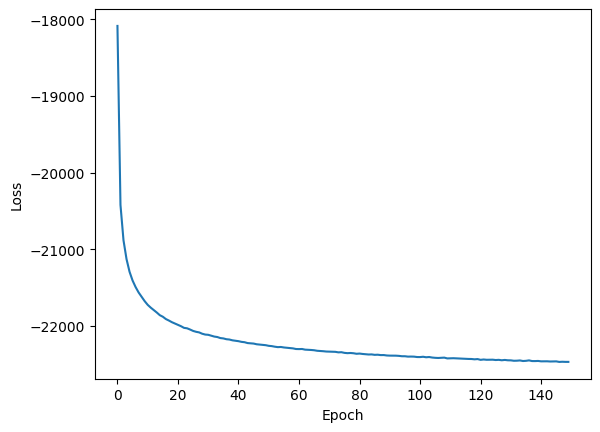

In [179]:
from torch.utils.data import Dataset

# first use the Moons dataset
n_samples = 2000
n_epochs = 150
blocks = 8
hidden_size = 128
batch_size = 150
input_size = 64
condition_size = 1

# create MNISTdata seperating images and labels
class ImageOnlyMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        # Load the MNIST dataset
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Return only the image, not the label
        return self.dataset[index][0]
    
class LabelsOnlyMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        # Load the MNIST dataset
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Return only the image, not the label
        return self.dataset[index][1]

# Specify your desired transforms (excluding the ToTensor transform if you only want PIL images)
transform = transforms.Compose([DownsampleTransform(target_shape=(8, 8)), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# Create the custom dataset without labels
mnist_images_dataset = ImageOnlyMNIST(root='./data', train=True, transform=transform, download=True)

mnist_labels_dataset = LabelsOnlyMNIST(root='./data', train=True, transform=transform, download=True)

# function to train the conditional RealNVP
def train_conditional_inn_mnist(inn, data, condition, batch_size, epochs, visualize=False):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    dataset = list(zip(data, condition))
    train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            X_batch, condition_batch = batch
            X_batch = X_batch.resize(batch_size,64)
            condition_batch = condition_batch.resize(batch_size,1)
            X_batch = X_batch.float()
            condition_batch = condition_batch.float()
            optimizer.zero_grad()
            z, log_det_J = inn(X_batch, condition_batch)
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

inn_cond_mnist = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn_mnist(inn_cond_mnist, mnist_images_dataset, mnist_labels_dataset, batch_size=batch_size, epochs=n_epochs, visualize=True)

<div style="color:green; font-weight:bold">

Comment: The given code snippet for MNIST does not work well, and we had to rewrite a large part of it. The code is essentially correct, with minor difference of the normalized loss function persisting.
</div>

Text(0.5, 0.98, 'generated samples')

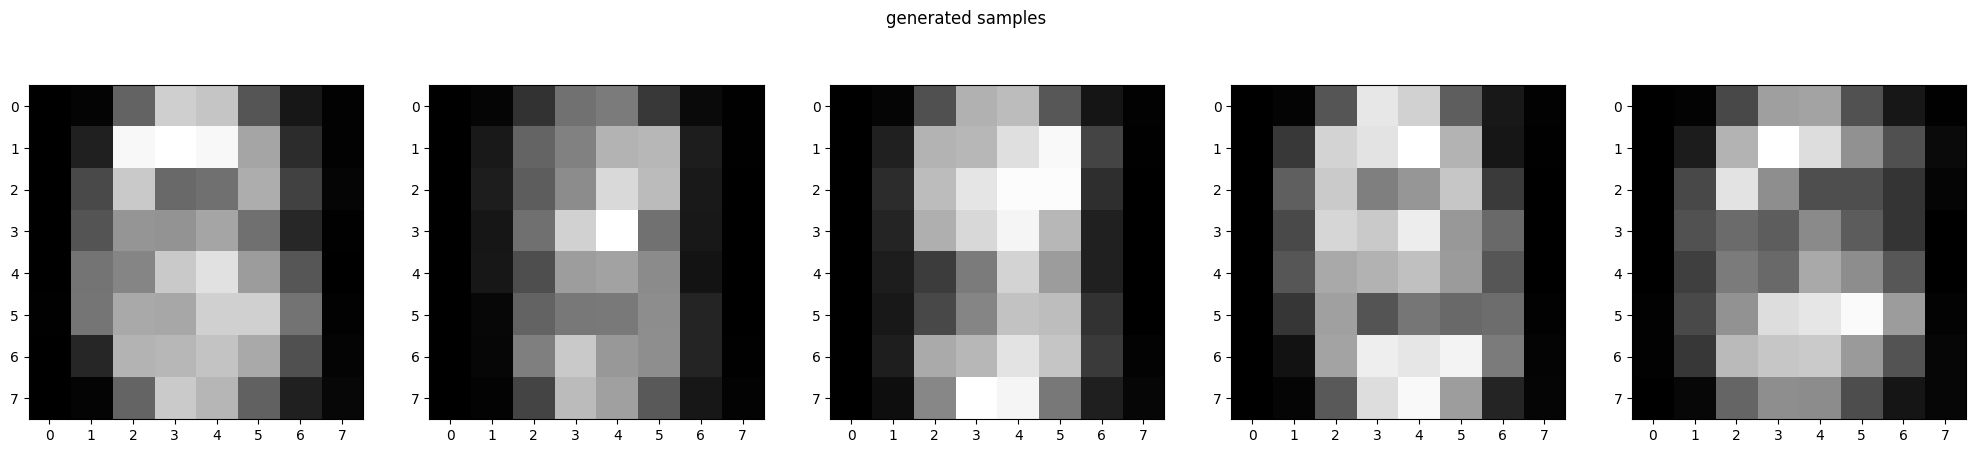

In [180]:
# Generate samples using the inverse function of our model with details set to zero
z = torch.randn(5,64)
# z[:,:k] = float(X.mean())

generated_samples = inn_cond_mnist.inverse(z,torch.tensor([0,1,2,3,4]).reshape(5,1)).detach().numpy()

# Rescale the generated samples to the original scale 
# generated_samples_rescaled = generated_samples * X.std(axis=0) + X.mean(axis=0)
fig, axs = plt.subplots(ncols=len(generated_samples), nrows = 1, figsize = (len(generated_samples)*5, 5))
for i in range(len(generated_samples_rescaled)):#
    sample = generated_samples_rescaled[i]
    ax = axs[i]
    ax.imshow(sample.reshape(8, 8), cmap="gray")
fig.suptitle("generated samples")

<div style="color:green; font-weight:bold">

Comment: It might be possible, that the training hyperparameters are not tuned correctly. The code has no major mistakes, despite that it failed to use the sample() function defined, but instead rewrote the process. The number of epochs does not seem sufficient. With more training, results might improve.
</div>

The generated data does not have any connection at all to the labels, and would not vary when the labels are changed. Since the loss function has already descended incredibly low, consider the encoding-decoding methods used for 3 in 4. 

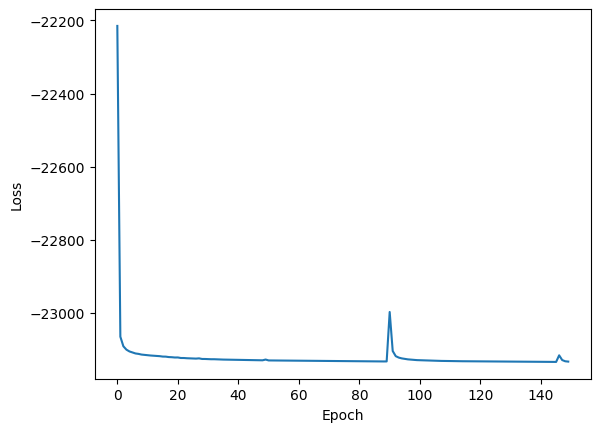

In [181]:
def train_cond_inn_mnist_encoding(inn, data, condition, batch_size, epochs, k, visualize=False):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    dataset = list(zip(data, condition))
    train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            X_batch, condition_batch = batch
            # print(X_batch)
            X_batch = X_batch[0].resize(batch_size,64)
            condition_batch = condition_batch.resize(batch_size,1)
            X_batch = X_batch.float()
            condition_batch = condition_batch.float()
            optimizer.zero_grad()
            z, log_det_J = inn(X_batch, condition_batch)
            z_recon = z
            z_recon[:,k:] = 0
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) \
                - torch.mean(log_det_J) + torch.mean((inn.inverse(z_recon, condition_batch)-X_batch)**2)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()



inn_cond_mnist_en = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_cond_inn_mnist_encoding(inn=inn_cond_mnist_en, data=mnist_dataset, condition = mnist_labels_dataset,  batch_size=batch_size, epochs=n_epochs, k = 8,
                              visualize=True)

Text(0.5, 0.98, 'generated samples')

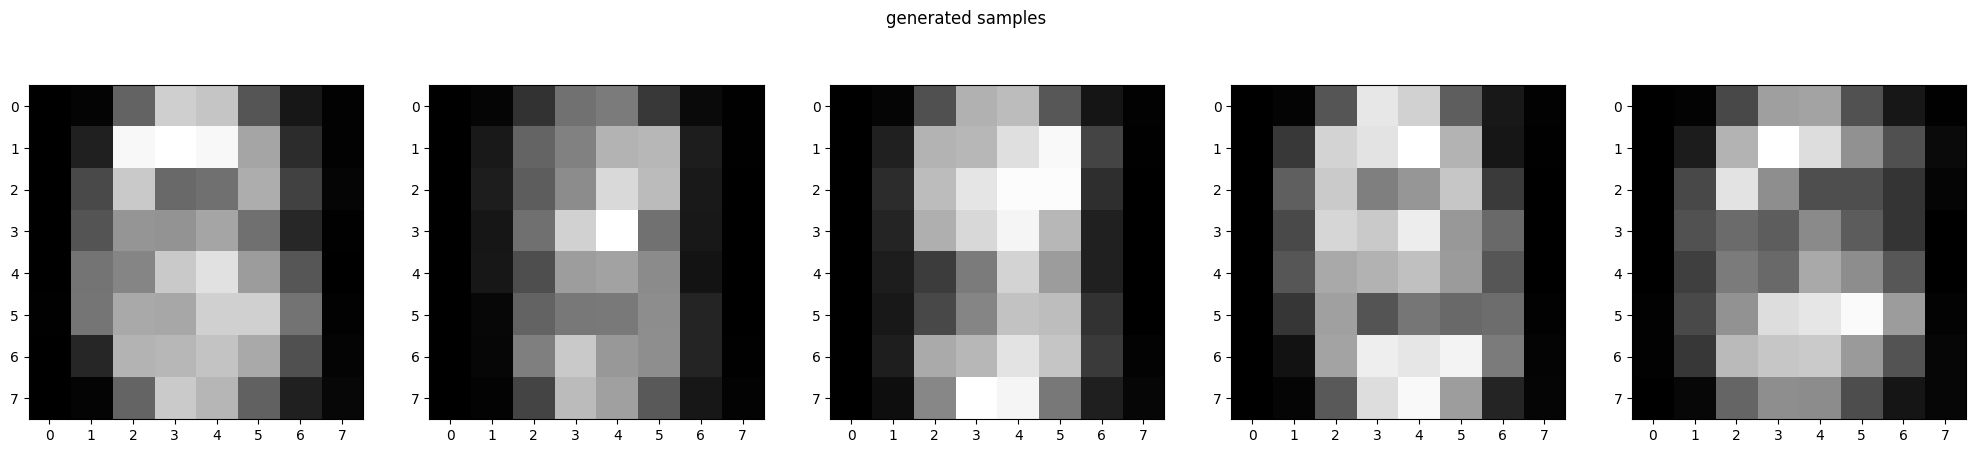

In [182]:
# Generate samples using the inverse function of our model with details set to zero
z = torch.randn(5,64)
# z[:,:k] = float(X.mean())

generated_samples = inn_cond_mnist_en.inverse(z,torch.tensor([1,2,3,4,5]).reshape(5,1)).detach().numpy()

# Rescale the generated samples to the original scale TODO
# generated_samples_rescaled = generated_samples * X.std(axis=0) + X.mean(axis=0)
fig, axs = plt.subplots(ncols=len(generated_samples), nrows = 1, figsize = (len(generated_samples)*5, 5))
for i in range(len(generated_samples_rescaled)):#
    sample = generated_samples_rescaled[i]
    ax = axs[i]
    ax.imshow(sample.reshape(8, 8), cmap="gray")
fig.suptitle("generated samples")

Text(0.5, 0.98, 'generated samples')

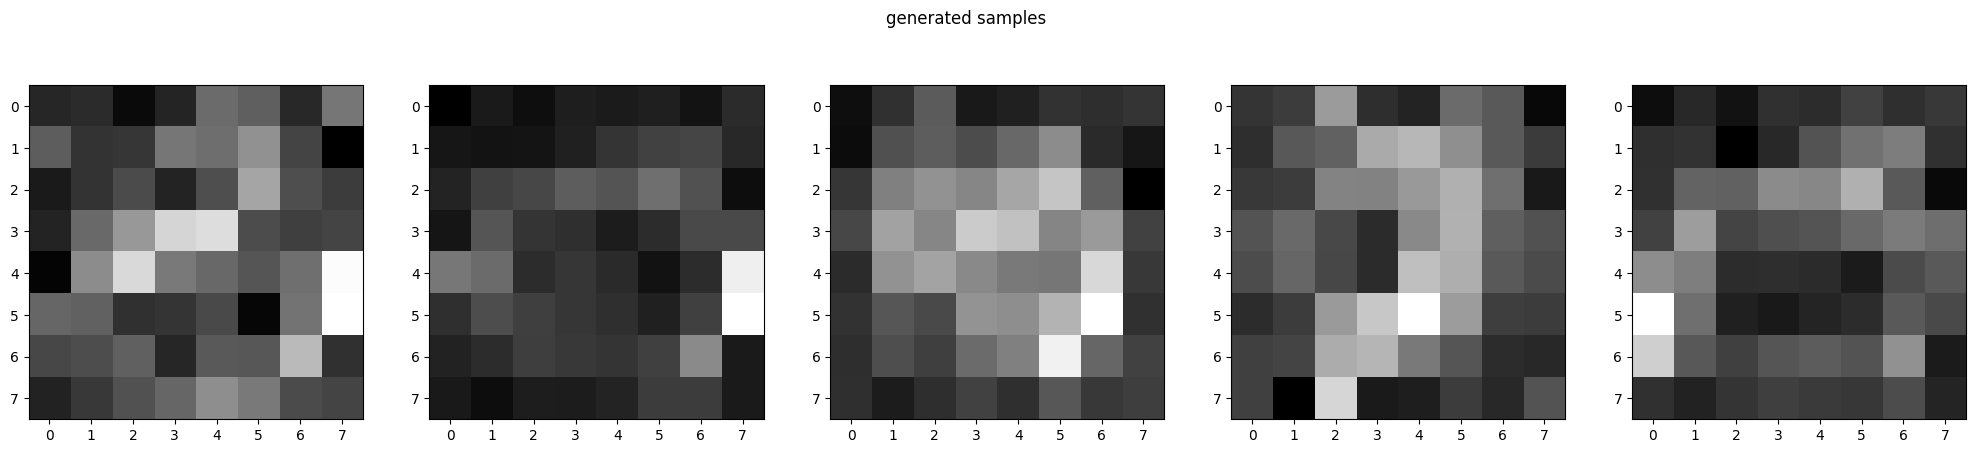

In [183]:
num_samples = 5

conditions = torch.from_numpy(np.random.randint(0, 2, num_samples)).float().view(-1, 1)
conditions_1 = torch.ones(num_samples, 1).float().view(-1, 1)
conditions_0 = torch.zeros(num_samples, 1).float().view(-1, 1)
z_inv = inn_cond_mnist_en.sample(num_samples, conditions)
z_inv_1 = inn_cond_mnist_en.sample(num_samples, conditions_1)
z_inv_0 = inn_cond_mnist_en.sample(num_samples, conditions_0)


fig, axs = plt.subplots(ncols=num_samples, nrows = 1, figsize = (num_samples*5, 5))
for i in range(num_samples):#
    sample = z_inv_1[i].detach()
    ax = axs[i]
    ax.imshow(sample.reshape(8, 8), cmap="gray")
fig.suptitle("generated samples")

The result is still not even remotely related to the labels. The reason might be that the training configuration is not efficient, or the absolute value of reconstruction loss being too small to make a difference.

<div style="color:green; font-weight:bold">

Comment: Since the training is not very successful, we did not apply random forest to the results. However, it is best that a statistical visualization is present, so that results may be well observed.
</div>